# __Character-Level Generatively Pretrained Transformer (GPT)__
### __Dataset: William Blake – Poems__  



## __1. Data Preprocessing__
### __1.1 Load and Clean the Dataset__

In [2]:
# 1.1 Load and clean the dataset
import re, torch
from collections import Counter

dataset_path = "william_blake_poems.txt"
with open(dataset_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

# Strip Project Gutenberg headers / footers
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK"
end_marker   = "*** END OF THE PROJECT GUTENBERG EBOOK"
s_idx, e_idx = raw_text.find(start_marker), raw_text.find(end_marker)
if s_idx != -1 and e_idx != -1:
    text = raw_text[s_idx + len(start_marker): e_idx].strip()
else:
    text = raw_text

# Basic cleanup
text = re.sub(r"\n\s*\n", "\n\n", text)
text = re.sub(r"Project Gutenberg.*", "", text)
text = re.sub(r"www\.gutenberg\.org.*", "", text)

print(f"Cleaned text length: {len(text)} characters")
print("Sample:\n", text[:400])

Cleaned text length: 30958 characters
Sample:
 SONGS OF INNOCENCE AND OF EXPERIENCE ***

          [Picture: Image of Blake’s original page of The Tyger]

                            SONGS OF INNOCENCE
                                   AND
                              OF EXPERIENCE

                             BY WILLIAM BLAKE

                 [Picture: The Astolaf Press, Guildford]

                       LONDON: R. BRIMLEY JOHNSON.
     


### __1.2 Character Tokenization and Vocab__

In [3]:
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
vocab_size = len(chars)

print(f"\nUnique characters (vocab size): {vocab_size}")


Unique characters (vocab size): 73


In [4]:
print(f'\nCharacter to Index representation: {char_to_idx}', "\n\n")
print(f'\nIndex to Character representation: {idx_to_char}')


Character to Index representation: {'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, '*': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'A': 12, 'B': 13, 'C': 14, 'D': 15, 'E': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'Q': 28, 'R': 29, 'S': 30, 'T': 31, 'U': 32, 'V': 33, 'W': 34, 'X': 35, 'Y': 36, 'Z': 37, '[': 38, ']': 39, 'a': 40, 'b': 41, 'c': 42, 'd': 43, 'e': 44, 'f': 45, 'g': 46, 'h': 47, 'i': 48, 'j': 49, 'k': 50, 'l': 51, 'm': 52, 'n': 53, 'o': 54, 'p': 55, 'q': 56, 'r': 57, 's': 58, 't': 59, 'u': 60, 'v': 61, 'w': 62, 'x': 63, 'y': 64, 'z': 65, 'è': 66, 'é': 67, '—': 68, '‘': 69, '’': 70, '“': 71, '”': 72} 



Index to Character representation: {0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: '*', 6: ',', 7: '-', 8: '.', 9: ':', 10: ';', 11: '?', 12: 'A', 13: 'B', 14: 'C', 15: 'D', 16: 'E', 17: 'F', 18: 'G', 19: 'H', 20: 'I', 21: 'J', 22: 'K', 23: 'L', 24: 'M', 25: 'N', 26: 'O', 27: 'P', 28: 'Q', 29: 'R', 30: 'S', 31: '

### __1.3 Encoding, Sequence Creation & Split__

In [5]:
# Encode/decode helpers
def encode(s): return [char_to_idx[c] for c in s]
def decode(ids): return ''.join([idx_to_char[i] for i in ids])

ids = encode(text)
context_len = 256
print("\nContext length:", context_len)

# Create overlapping sequences
X, Y = [], []
for i in range(len(ids) - context_len):
    X.append(ids[i:i+context_len])
    Y.append(ids[i+1:i+context_len+1])
print("\nTotal sequences:", len(X))

# Train/Val split
split = int(0.9 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_val,   Y_val   = X[split:], Y[split:]

print(f"\nTrain: {len(X_train)} | Val: {len(X_val)}")


Context length: 256

Total sequences: 30702

Train: 27631 | Val: 3071


## __2. Building the GPT Model__
### __2.1 Embedding Layers__

In [6]:
import torch
import torch.nn as nn

class CharEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, context_len):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb   = nn.Embedding(context_len, d_model)
    def forward(self, x):
        B, T = x.shape
        pos = torch.arange(0, T, device=x.device)
        return self.token_emb(x) + self.pos_emb(pos)[None, :, :]

### __2.2 Multi-Head Self-Attention__

In [7]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_head  = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3*d_model)
        self.proj = nn.Linear(d_model, d_model)
    def forward(self, x):
        B, T, D = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.n_heads, self.d_head).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]      # (B, heads, T, d_head)
        attn = (q @ k.transpose(-2,-1)) / (self.d_head**0.5)
        mask = torch.tril(torch.ones(T, T, device=x.device))
        attn = attn.masked_fill(mask==0, float("-inf"))
        attn = torch.softmax(attn, dim=-1)
        out  = attn @ v                       # (B, heads, T, d_head)
        out  = out.transpose(1,2).contiguous().view(B,T,D)
        return self.proj(out)

### __2.3 Feed-Forward + Transformer Block__

In [8]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, x): return self.net(x)

class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, n_heads)
        self.ff   = FeedForward(d_model, d_ff)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = x + self.drop(self.attn(self.ln1(x)))
        x = x + self.drop(self.ff(self.ln2(x)))
        return x

### __2.4 Complete GPT Model__

In [9]:
class CharGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, context_len, dropout):
        super().__init__()
        self.embed  = CharEmbedding(vocab_size, d_model, context_len)
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ])
        self.ln_f   = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        x = self.embed(x)
        for blk in self.blocks:
            x = blk(x)
        return self.fc_out(self.ln_f(x))

## __3. Training the Model__
### __3.1 Hyperparameters and Training Setup__

In [10]:
import math, random, torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

device = "cuda" if torch.cuda.is_available() else "cpu"
print("\nDevice:", device)

num_heads   = 2
num_layers  = 2
hidden_dim  = 128
ff_dim      = 512
dropout     = 0.4
batch_size  = 64
epochs      = 25
lr          = 3e-4
warmup_steps= 1000

print(f"""
Heads: {num_heads}
Layers: {num_layers}
Hidden dim: {hidden_dim}
Feed-Forward dim: {ff_dim}
Batch size: {batch_size}
Epochs: {epochs}
""")


Device: cuda

Heads: 2
Layers: 2
Hidden dim: 128
Feed-Forward dim: 512
Batch size: 64
Epochs: 25



In [11]:
model = CharGPT(vocab_size, hidden_dim, num_layers,
                num_heads, ff_dim, context_len, dropout).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9,0.95), weight_decay=0.05)

def lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    return 0.5 * (1 + math.cos((step - warmup_steps)/(10000 - warmup_steps)*math.pi))

scheduler = LambdaLR(optimizer, lr_lambda)

### __3.2 Training Loop__

In [12]:
def get_batch(X, Y, bs):
    idx = random.sample(range(len(X)), bs)
    xb = torch.tensor([X[i] for i in idx], device=device)
    yb = torch.tensor([Y[i] for i in idx], device=device)
    return xb, yb

steps_per_epoch = len(X_train)//batch_size
train_losses, val_losses = [], []
best_val=float("inf"); bad_epochs=0; patience=3

for ep in range(epochs):
    model.train(); running=0.0
    for st in range(steps_per_epoch):
        xb,yb=get_batch(X_train,Y_train,batch_size)
        logits=model(xb)
        loss=criterion(logits.view(-1,vocab_size), yb.view(-1))
        optimizer.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step(); scheduler.step()
        running += loss.item()
        if (st+1)%200==0:
            print(f"Epoch {ep+1} Step {st+1}/{steps_per_epoch} | Train Loss: {running/(st+1):.4f}")

    model.eval()
    with torch.no_grad():
        xv,yv=get_batch(X_val,Y_val,batch_size)
        val_loss=criterion(model(xv).view(-1,vocab_size), yv.view(-1))
    train_losses.append(running/steps_per_epoch); val_losses.append(val_loss.item())
    print(f"Epoch {ep+1} Done | Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f}")
    if val_losses[-1]<best_val:
        best_val=val_losses[-1]; bad_epochs=0
        torch.save(model.state_dict(),"best_char_gpt.pt")
    else:
        bad_epochs+=1
        if bad_epochs>=patience:
            print("Early stopping triggered."); break

Epoch 1 Step 200/431 | Train Loss: 4.0086
Epoch 1 Step 400/431 | Train Loss: 3.4749
Epoch 1 Done | Train 3.4168 | Val 2.6139
Epoch 2 Step 200/431 | Train Loss: 2.5555
Epoch 2 Step 400/431 | Train Loss: 2.5077
Epoch 2 Done | Train 2.5019 | Val 2.4363
Epoch 3 Step 200/431 | Train Loss: 2.4053
Epoch 3 Step 400/431 | Train Loss: 2.3862
Epoch 3 Done | Train 2.3835 | Val 2.4135
Epoch 4 Step 200/431 | Train Loss: 2.3223
Epoch 4 Step 400/431 | Train Loss: 2.2997
Epoch 4 Done | Train 2.2956 | Val 2.3180
Epoch 5 Step 200/431 | Train Loss: 2.2058
Epoch 5 Step 400/431 | Train Loss: 2.1613
Epoch 5 Done | Train 2.1539 | Val 2.1616
Epoch 6 Step 200/431 | Train Loss: 2.0038
Epoch 6 Step 400/431 | Train Loss: 1.9621
Epoch 6 Done | Train 1.9565 | Val 2.0477
Epoch 7 Step 200/431 | Train Loss: 1.8505
Epoch 7 Step 400/431 | Train Loss: 1.8248
Epoch 7 Done | Train 1.8213 | Val 1.9963
Epoch 8 Step 200/431 | Train Loss: 1.7512
Epoch 8 Step 400/431 | Train Loss: 1.7318
Epoch 8 Done | Train 1.7289 | Val 1.9234


### Saving My model weights

In [14]:
# Save trained model weights
MODEL_PATH = "william_blake_charGPT_weights.pt"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model weights saved successfully at: {MODEL_PATH}")

Model weights saved successfully at: william_blake_charGPT_weights.pt


### __3.3 Text Generation__

In [13]:
def generate_text(model, start_text="tyger, tyger, ", max_new=400,
                  temperature=0.8, top_k=50):
    model.eval()
    ids = encode(start_text)
    for _ in range(max_new):
        x=torch.tensor([ids[-context_len:]], device=device)
        logits=model(x)[:,-1,:]/temperature
        sorted_logits, sorted_idx=torch.sort(logits, descending=True)
        sorted_logits=sorted_logits[:,:top_k]; sorted_idx=sorted_idx[:,:top_k]
        probs=torch.softmax(sorted_logits, dim=-1)
        next_id=sorted_idx[0, torch.multinomial(probs,1)].item()
        ids.append(next_id)
    return decode(ids)

print("\nGenerated sample:\n")
#print(generate_text(model, start_text="tyger, tyger, "))

print("\nGenerated Sample:\n")
print(generate_text(model, start_text = "Your smile"))


Generated sample:


Generated Sample:

Your smiles,
From head his kissed my flowelfies,
Night where a sorrom and,
And moan the cand I wantery angel a live their love,
When hen the band you the sunk his gorns he!’

ANDENSORROSEN

Where flower like child her thorn, the bead.

The gradled up and meen
On seen
While their beounds areys,
Till in the shou shall way theep?

‘Lyca be ey song with like should.

Then in a shepers like the seep.

THE Boy, a


### __3.4 Plot Loss Curves__

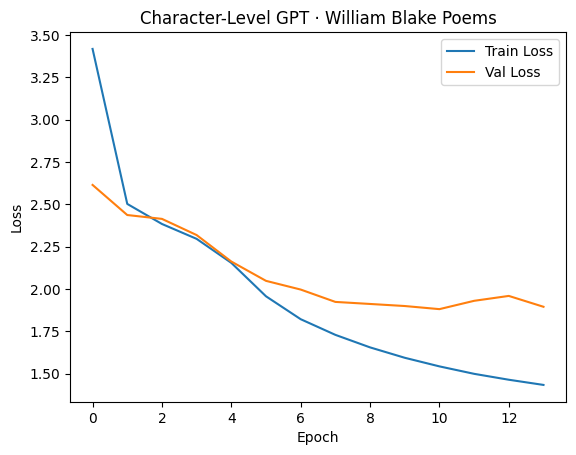

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Character-Level GPT · William Blake Poems")
plt.legend(); plt.show()

### Model can be reloaded from here

In [16]:
# Load model weights
# Make sure the architecture definition is exactly the same
model = CharGPT(vocab_size, hidden_dim, num_layers, num_heads, ff_dim, context_len, dropout)
model.load_state_dict(torch.load("william_blake_charGPT_weights.pt", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully and set to evaluation mode.")

Model loaded successfully and set to evaluation mode.
